In [98]:
%pylab inline
from pygadgetreader import readsnap 
from biff import compute_coeffs_discrete
from scipy import special
from jellyfish import com
from jellyfish import profiles

Populating the interactive namespace from numpy and matplotlib


In [3]:
pos = readsnap('../../../MW_anisotropy/data/LMC4_beta1_000', 'pos', 'dm')

Returning DM    Positions


In [177]:
r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5
r_cut = np.where(r<100)[0]

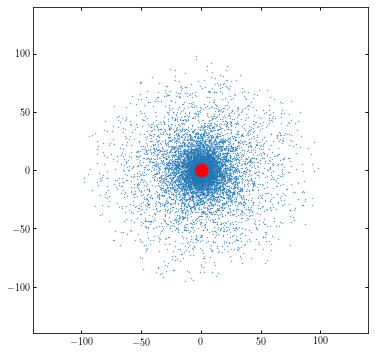

In [180]:
rand = np.random.randint(0, len(r[r_cut]), 10000)
figure(figsize=(6,6))
scatter(pos[r_cut][rand,1], pos[r_cut][rand,2], s=0.1)
xlim(-140, 140)
ylim(-140, 140)

scatter(0,0, c='r', s=160)

In [181]:
N_part = len(r[r_cut])
mass = 1E12
mass_p = N_part/mass

In [185]:
mass/N_part

507925.9301774541

In [187]:
1E12/N_part

507925.9301774541

In [182]:
mass_p

1.968791e-06

In [183]:
com.CM(pos[r_cut], pos[r_cut], np.ones(N_part))

0.26265126


(array([-0.00833633, -0.00858836, -0.00245657]),
 array([-0.00833633, -0.00858836, -0.00245657]))

In [125]:
def density_profile(pos, rmin, rmax, nbins):
    rho = np.zeros(nbins)
    r = np.linspace(rmin, rmax, nbins)
    dr = r[1]-r[0]
    r_pos = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    for i in range(len(r)-1):
        index = np.where((r_pos<r[i+1]) & (r_pos>r[i]))[0]
        V = 4/3. * np.pi * (r[i+1]**3 - r[i]**3)
        rho[i] = len(index)/V
    return rho, r+(dr/2)
    

In [126]:
rho_sph, r_sph = density_profile(pos[r_cut], 2, 100, 100)

In [169]:
len(pos)

2500000

In [173]:
2500000/len(pos[r_cut])

1.2698148254436352

In [174]:
teo_halo = profiles.Hernquist(len(pos[r_cut])*1.2698148254436352, r_sph, 12.7)
teo_NFW = profiles.NFW(N_part, r_sph, 40)

In [175]:
rho_teo = teo_halo.density()
rho_NFW = teo_NFW.density()

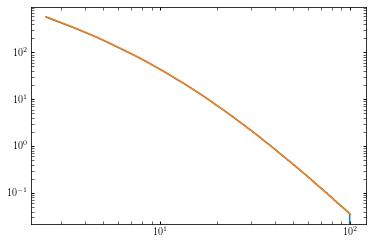

In [176]:
loglog(r_sph, rho_sph)
loglog(r_sph, rho_teo)
#loglog(r_sph, rho_NFW)

In [13]:
compute_coeffs_discrete?

In [7]:
xyz  = np.array([pos[r_cut][:,0], pos[r_cut][:,1], pos[r_cut][:,2]]).T

In [11]:
compute_coeffs_discrete?

In [18]:
S, T = compute_coeffs_discrete(xyz.astype(float), np.ones(N_part), 10, 1, 10)

In [21]:
S2, T2 = compute_coeffs_discrete(xyz.astype(float), np.ones(N_part), 10, 1, 12)

In [19]:
print(N_part)

1968791


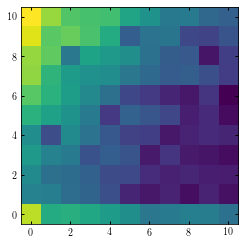

In [9]:
imshow(np.log10(np.abs(S[:,:,0].T)), origin='lower')

In [20]:
S[:,0,0]

array([ 2.13770723e+06,  5.36692351e+04, -1.53026697e+04, -1.13718839e+04,
       -6.33106227e+03, -3.00844824e+03, -1.09145059e+03, -6.17722610e+00,
        4.45474233e+02,  5.34310277e+02,  4.06478497e+02])

In [23]:
S2[:,0,0]

array([ 2.34522326e+06, -1.65276967e+04, -2.14364223e+04, -1.20850029e+04,
       -5.89348195e+03, -2.26600871e+03, -3.74858854e+02,  5.20147093e+02,
        7.04327708e+02,  5.59060160e+02,  2.77582531e+02])

In [75]:
def write_halo(pos, halo_name):
    v = np.ones(len(pos[:,0]))
    array_pos = np.array([pos[:,0], pos[:,1], pos[:,2], v, v, v, v]).T
    np.savetxt(halo_name, array_pos)
    return 0

In [54]:
def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

def Anl_array(nmax, lmax):
    A_nl_array = np.zeros((nmax, lmax))
    for j in range(nmax):
        for i in range(lmax):
            A_nl_array[j][i] = Anl(j, i)
    return A_nl_array

def coeff_energy(S, T, m, nmax, lmax):
    A_nl = Anl_array(nmax+1, lmax+1)
    A = (S[:,:,m]**2 + T[:,:,m]**2)**0.5/A_nl
    #im = ax.imshow(np.log10(np.abs(A/A_nl)).T, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    #fig.colorbar()
    return A

def asana_halo(xyz, s, q):
    """
    s=c/a
    q=b/a
    oblate : T < 0.33
    prolate : T > 0.66
    triaxial : 0.33 < T < 0.66
    T = (1-q^2) / (1-s^2)
    
    """
    x = xyz[:,0]
    y = xyz[:,1]/q
    z = xyz[:,2]/s
    print((1-q**2)/(1-s**2))
    return np.array([x, y, z]).T
    
def lotus_halo(xyz, mp, total_mass, rs_in, rs_out):
    """
    scale halos 
    """
    scale_f = rs_in/rs_out
    x = xyz[:,0]/scale_f
    y = xyz[:,1]/scale_f
    z = xyz[:,2]/scale_f
    n_particles = total_mass / mp
    rand_sample = np.random.randint(0, len(x), n_particles)
    print(n_particles)
    return np.array([x[rand_sample], y[rand_sample], z[rand_sample]].T)
    
    

In [34]:
s1 = np.linspace(0, 1)
t1 = np.linspace(0, 1)
S1, T1 = np.meshgrid(s1, t1)
#T = 1-S1**2 / (1-T1**2)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


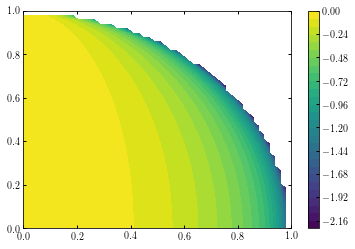

In [16]:
contourf(S1, T1, np.log10(T), 30)
colorbar()

In [36]:
A = coeff_energy(S, T, 0, 10, 10)

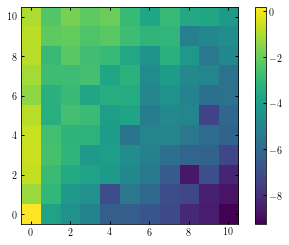

In [37]:
imshow(np.log10(np.abs(A)), origin='lower')
colorbar()

In [19]:
xyz_2 = asana_halo(xyz, 0.5, 1)

0.0


In [20]:
xyz_s1 = asana_halo(xyz, 0.5, 1)
xyz_s2 = asana_halo(xyz, 0.75, 1)
xyz_s3 = asana_halo(xyz, 0.9, 1)
xyz_q1 = asana_halo(xyz, 0.9, 0.5)
xyz_q2 = asana_halo(xyz, 0.9, 0.75)
xyz_q3 = asana_halo(xyz, 0.9, 0.9)

0.0
0.0
0.0
3.9473684210526327
2.302631578947369
1.0


In [45]:
xyz_t1 = asana_halo(xyz, 0.2, 0.8)
xyz_t2 = asana_halo(xyz, 0.4, 0.8)
xyz_t3 = asana_halo(xyz, 0.7, 0.8)


0.3749999999999999
0.42857142857142844
0.7058823529411762


In [68]:
savetxt?

In [76]:
write_halo(xyz, 'spherical_halo.txt')

0

In [77]:
write_halo(xyz, 'spherical_halo.txt')
write_halo(xyz_s1, 's1_halo.txt')
write_halo(xyz_q1, 'q1_halo.txt')
write_halo(xyz_t1, 't1_halo.txt')

0

In [22]:
random2 = np.random.randint(0, len(xyz_2[:,0]), 10000)

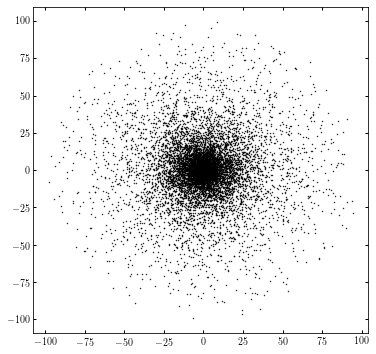

In [23]:
figure(figsize=(6,6))
scatter(xyz_2[random2,0], xyz_2[random2,1], c='k', s=0.2)

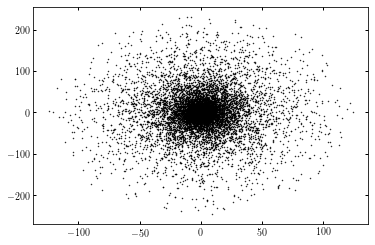

In [24]:
scatter(xyz_t2[random2,1], xyz_t2[random2,2], c='k', s=0.2)

In [25]:
S2, T2 = compute_coeffs_discrete(xyz_2.astype(float), mass_p*np.ones(N_part), 10, 10, 12)

In [26]:
Ss1, Ts1 = compute_coeffs_discrete(xyz_s1.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
Ss2, Ts2 = compute_coeffs_discrete(xyz_s2.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
Ss3, Ts3 = compute_coeffs_discrete(xyz_s3.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
Sq1, Tq1 = compute_coeffs_discrete(xyz_q1.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
Sq2, Tq2 = compute_coeffs_discrete(xyz_q2.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
Sq3, Tq3 = compute_coeffs_discrete(xyz_q3.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
St1, Tt1 = compute_coeffs_discrete(xyz_t1.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
St2, Tt2 = compute_coeffs_discrete(xyz_t2.astype(float), mass_p*np.ones(N_part), 10, 10, 12)
St3, Tt3 = compute_coeffs_discrete(xyz_t3.astype(float), mass_p*np.ones(N_part), 10, 10, 12)

In [27]:
As1 = coeff_energy(Ss1, Ts1, 0, 10, 10)
As2 = coeff_energy(Ss2, Ts2, 0, 10, 10)
As3 = coeff_energy(Ss3, Ts3, 0, 10, 10)
Aq1 = coeff_energy(Sq1, Tq1, 0, 10, 10)
Aq2 = coeff_energy(Sq2, Tq2, 0, 10, 10)
Aq3 = coeff_energy(Sq3, Tq3, 0, 10, 10)
At1 = coeff_energy(St1, Tt1, 0, 10, 10)
At2 = coeff_energy(St2, Tt2, 0, 10, 10)
At3 = coeff_energy(St3, Tt3, 0, 10, 10)

In [121]:
A2 = coeff_energy(S2, T2, 0, 10, 10)

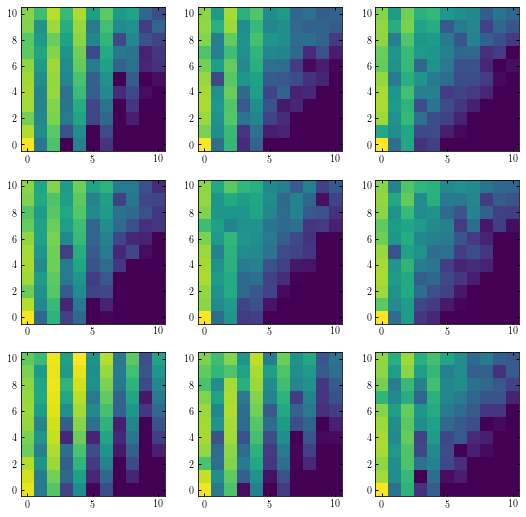

In [28]:
fig, ax = subplots(3, 3, figsize=(9, 9))
im = ax[0][0].imshow(np.log10(np.abs(As1)), origin='lower', vmin=-6, vmax=0.2)
im = ax[0][1].imshow(np.log10(np.abs(As2)), origin='lower', vmin=-6, vmax=0.2)
im = ax[0][2].imshow(np.log10(np.abs(As3)), origin='lower', vmin=-6, vmax=0.2)
im = ax[1][0].imshow(np.log10(np.abs(Aq1)), origin='lower', vmin=-6, vmax=0.2)
im = ax[1][1].imshow(np.log10(np.abs(Aq2)), origin='lower', vmin=-6, vmax=0.2)
im = ax[1][2].imshow(np.log10(np.abs(Aq3)), origin='lower', vmin=-6, vmax=0.2)
im = ax[2][0].imshow(np.log10(np.abs(At1)), origin='lower', vmin=-6, vmax=0.2)
im = ax[2][1].imshow(np.log10(np.abs(At2)), origin='lower', vmin=-6, vmax=0.2)
im = ax[2][2].imshow(np.log10(np.abs(At3)), origin='lower', vmin=-6, vmax=0.2)

#colorbar(im)

In [1]:
#St4, Tt4 = compute_coeffs_discrete(xyz_t3.astype(float), mass_p*np.ones(N_part), 10, 10, 12)

In [78]:
len(xyz)

1968791

In [57]:
At4 = coeff_energy(St4, Tt4, 0, 10, 10)

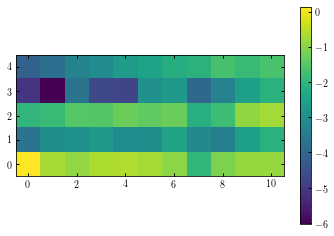

In [62]:
imshow(np.log10(np.abs(At4)).T, origin='lower')
colorbar()

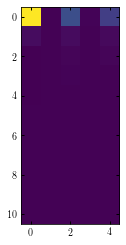

In [60]:
imshow(St4[:,:,0])